In [4]:
import os
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Désactive les logs CUDA
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

# Vérification propre
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f'✅ GPU P100 configuré : {gpus[0]}')
    except RuntimeError as e:
        print('⚠️ Erreur configuration GPU :', e)
else:
    print('❌ Aucun GPU détecté')

E0000 00:00:1745807962.714741      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745807962.778784      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


✅ GPU P100 configuré : PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [5]:
import os
import tarfile
import xml.etree.ElementTree as ET
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array

In [7]:
# ⚙️ 2. Chemins

input_dir = '/kaggle/input/image-annotation/images/Images'
annotation_dir = '/kaggle/input/image-annotation/annotation/Annotation'  # attention : il y a un sous-dossier "Annotation"
output_dir = '/kaggle/working/chien_project/processed_1'
os.makedirs(output_dir, exist_ok=True)

In [9]:
img_size = (160, 160)
augment_per_image = 5

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    channel_shift_range=20.0,
    fill_mode='nearest'
)



In [8]:
import os
# Affichez le contenu du dossier racine
print("Contenu de /kaggle/input/image-annotation :", os.listdir("/kaggle/working"))

Contenu de /kaggle/input/image-annotation : ['.virtual_documents', 'chien_project']


In [10]:
for breed_folder in os.listdir(input_dir):
    breed_path = os.path.join(input_dir, breed_folder)
    if not os.path.isdir(breed_path):
        continue

    annotation_breed_path = os.path.join(annotation_dir, breed_folder)
    if not os.path.isdir(annotation_breed_path):
        print(f"⚠️ Dossier d'annotations manquant pour {breed_folder}")
        continue

    output_breed_dir = os.path.join(output_dir, breed_folder)
    os.makedirs(output_breed_dir, exist_ok=True)

    for img_file in os.listdir(breed_path):
        try:
            img_name = os.path.splitext(img_file)[0]
            img_path = os.path.join(breed_path, img_file)

            # Correction du chemin XML
            annotation_img_folder = os.path.join(annotation_breed_path, img_name)
            # xml_file_path = os.path.join(annotation_img_folder, f"{img_name}.xml")  # Ligne corrigée

            if not os.path.isfile(annotation_img_folder):  # Vérification corrigée
                print(f"⚠️ Annotation manquante pour {img_name} (fichier: {annotation_img_folder})")
                continue

            # Lecture des annotations avec vérification
            tree = ET.parse(annotation_img_folder)
            root = tree.getroot()
            
            # Vérification de la structure XML
            obj = root.find('object')
            if obj is None:
                print(f"⚠️ Aucun objet détecté dans {annotation_img_folder}")
                continue
                
            box = obj.find('bndbox')
            if box is None:
                print(f"⚠️ Balise bndbox manquante dans {annotation_img_folder}")
                continue
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)

            # 📸 Ouvre, crope et resize l'image
            with Image.open(img_path).convert('RGB') as img:
                cropped = img.crop((xmin, ymin, xmax, ymax))
                resized = cropped.resize(img_size)

                img_array = img_to_array(resized).reshape((1,) + resized.size + (3,))

                # 🎨 Applique la data augmentation et sauvegarde
                prefix = img_name
                i = 0
                for batch in datagen.flow(img_array, batch_size=1,
                                          save_to_dir=output_breed_dir,
                                          save_prefix=prefix,
                                          save_format='jpeg'):
                    i += 1
                    if i >= augment_per_image:
                        break

        except Exception as e:
            print(f"Erreur avec {img_file} : {e}")

print("✅ Cropping + Data Augmentation terminés avec navigation dans les sous-dossiers d'annotations !")


✅ Cropping + Data Augmentation terminés avec navigation dans les sous-dossiers d'annotations !


In [11]:
import random
import shutil

# 📂 Dossier où mes images augmentées sont sauvegardées
input_dir = '/kaggle/working/chien_project/processed_1'

# 📂 Dossier où l'on va mettre le split final
output_base_dir = '/kaggle/working/chien_project/dataset_split_1'
train_dir = os.path.join(output_base_dir, 'train')
val_dir = os.path.join(output_base_dir, 'val')
# Création des dossiers train/val
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

In [12]:
import tensorflow as tf

from tensorflow.keras.models import Sequential , load_model , Model

from tensorflow.keras.layers import (Conv2D, MaxPooling2D, BatchNormalization,
                                     GlobalAveragePooling2D, Dense, Dropout, LeakyReLU,Flatten)

import matplotlib.pyplot as plt


In [13]:
# 📈 Pourcentage d'images dans le train
train_ratio = 0.8

In [14]:
# 🔄 Parcours de chaque race
for breed_folder in os.listdir(input_dir):
    breed_path = os.path.join(input_dir, breed_folder)
    if not os.path.isdir(breed_path):
        continue

    # Créer les sous-dossiers par race
    os.makedirs(os.path.join(train_dir, breed_folder), exist_ok=True)
    os.makedirs(os.path.join(val_dir, breed_folder), exist_ok=True)

    images = os.listdir(breed_path)
    random.shuffle(images)  # 🔀 Shuffle les images pour éviter les biais

    # 📊 Split en 80% / 20%
    split_index = int(len(images) * train_ratio)
    train_images = images[:split_index]
    val_images = images[split_index:]

    # 📤 Copier les images
    for img in train_images:
        shutil.copy2(os.path.join(breed_path, img), os.path.join(train_dir, breed_folder, img))
    for img in val_images:
        shutil.copy2(os.path.join(breed_path, img), os.path.join(val_dir, breed_folder, img))

    print(f"✔️ {breed_folder}: {len(train_images)} train / {len(val_images)} val")

print("\n✅ Split terminé : ton dossier est prêt pour l'entraînement !")


✔️ n02096051-Airedale: 807 train / 202 val
✔️ n02091134-whippet: 748 train / 187 val
✔️ n02095314-wire-haired_fox_terrier: 628 train / 157 val
✔️ n02102480-Sussex_spaniel: 604 train / 151 val
✔️ n02098413-Lhasa: 744 train / 186 val
✔️ n02108422-bull_mastiff: 624 train / 156 val
✔️ n02104029-kuvasz: 600 train / 150 val
✔️ n02115913-dhole: 599 train / 150 val
✔️ n02109961-Eskimo_dog: 600 train / 150 val
✔️ n02089078-black-and-tan_coonhound: 635 train / 159 val
✔️ n02104365-schipperke: 616 train / 154 val
✔️ n02108089-boxer: 603 train / 151 val
✔️ n02093647-Bedlington_terrier: 728 train / 182 val
✔️ n02113799-standard_poodle: 636 train / 159 val
✔️ n02093754-Border_terrier: 688 train / 172 val
✔️ n02096294-Australian_terrier: 784 train / 196 val
✔️ n02101006-Gordon_setter: 612 train / 153 val
✔️ n02105505-komondor: 616 train / 154 val
✔️ n02108915-French_bulldog: 636 train / 159 val
✔️ n02102177-Welsh_springer_spaniel: 600 train / 150 val
✔️ n02098105-soft-coated_wheaten_terrier: 624 trai

In [16]:
# Chemin vers votre dataset
dataset_path = "/kaggle/working/chien_project/dataset_split_1"  # Kaggle renomme avec des tirets
print("Contenu du dataset:", os.listdir(dataset_path))
# train_dir = os.path.join(dataset_path, "train")
# val_dir = os.path.join(dataset_path, "val")
train_dir = '/kaggle/working/chien_project/dataset_split_1/train'
val_dir=  '/kaggle/working/chien_project/dataset_split_1/val'

Contenu du dataset: ['train', 'val']


In [17]:
import tensorflow as tf
import numpy as np
import os
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [57]:
# ==============================================
# 1. Paramètres Globaux
# ==============================================

img_size = (160, 160)
BATCH_SIZE = 32  
EPOCHS = 70
BASE_LR = 1e-3
PATIENCE = 10

----------------------------------------------------

--------------------------------------------------------------------------------------------------

In [71]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2]  # Variation de luminosité
)
val_datagen = ImageDataGenerator(rescale=1./255) 

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 82306 images belonging to 120 classes.
Found 20580 images belonging to 120 classes.


In [72]:
# Crée un dictionnaire {nom_classe: index} en extrayant la partie après le tiret
classes = {v: k.split('-')[1] for k, v in train_generator.class_indices.items()}

# Affiche les classes pour vérification
print("Mapping des classes:")
for idx, name in classes.items():
    print(f"{idx}: {name}")

# Fonction utilitaire pour convertir les prédictions
def get_class_name(prediction):
    return classes[np.argmax(prediction)]


Mapping des classes:
0: Chihuahua
1: Japanese_spaniel
2: Maltese_dog
3: Pekinese
4: Shih
5: Blenheim_spaniel
6: papillon
7: toy_terrier
8: Rhodesian_ridgeback
9: Afghan_hound
10: basset
11: beagle
12: bloodhound
13: bluetick
14: black
15: Walker_hound
16: English_foxhound
17: redbone
18: borzoi
19: Irish_wolfhound
20: Italian_greyhound
21: whippet
22: Ibizan_hound
23: Norwegian_elkhound
24: otterhound
25: Saluki
26: Scottish_deerhound
27: Weimaraner
28: Staffordshire_bullterrier
29: American_Staffordshire_terrier
30: Bedlington_terrier
31: Border_terrier
32: Kerry_blue_terrier
33: Irish_terrier
34: Norfolk_terrier
35: Norwich_terrier
36: Yorkshire_terrier
37: wire
38: Lakeland_terrier
39: Sealyham_terrier
40: Airedale
41: cairn
42: Australian_terrier
43: Dandie_Dinmont
44: Boston_bull
45: miniature_schnauzer
46: giant_schnauzer
47: standard_schnauzer
48: Scotch_terrier
49: Tibetan_terrier
50: silky_terrier
51: soft
52: West_Highland_white_terrier
53: Lhasa
54: flat
55: curly
56: golden

In [73]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight


# Calcul des poids de classe pour gérer les déséquilibres
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

In [74]:
# ==============================================
# 3. Architecture CNN Ultra Optimisée P100
# ==============================================
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import AdamW

def build_model(num_classes):
    model = models.Sequential([
        layers.Conv2D(64, (3,3), padding='same', input_shape=(*img_size, 3)),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.1),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(128, (3,3), padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.1),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(256, (3,3), padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.1),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(512, (3,3), padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.1),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(512, (3,3), padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.1),
        layers.GlobalAveragePooling2D(),

        layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model


In [75]:
# ==============================================
# 4. Scheduler + Compilation P100
# ==============================================
steps_per_epoch = train_generator.samples // BATCH_SIZE

lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=BASE_LR,
    decay_steps=steps_per_epoch * EPOCHS
)

model = build_model(num_classes=train_generator.num_classes)

optimizer = AdamW(learning_rate=lr_schedule, weight_decay=1e-5)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=3)]
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [78]:
# ==============================================
# 5. Callbacks P100
# ==============================================
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=PATIENCE,
    restore_best_weights=True,
    mode='max'
)


checkpoint = ModelCheckpoint(
    'new_model.keras',  # Changé de .h5 à .keras
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

In [ ]:
# ==============================================
# 6. Entraînement P100
# ==============================================
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[early_stop, checkpoint],
    class_weight=class_weights,
    steps_per_epoch=steps_per_epoch,
    verbose=1
)

print("🏆 Entraînement terminé !")


Epoch 1/70
2572/2572 ━━━━━━━━━━━━━━━━━━━━ 528s 205ms/step - accuracy: 0.1968 - loss: 3.2008 - top_k_categorical_accuracy: 0.4000 - val_accuracy: 0.2567 - val_loss: 2.8671 - val_top_k_categorical_accuracy: 0.4838
Epoch 2/70
2572/2572 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.2500 - loss: 3.0513 - top_k_categorical_accuracy: 0.5312 - val_accuracy: 0.2637 - val_loss: 2.8412 - val_top_k_categorical_accuracy: 0.4889
Epoch 3/70
2572/2572 ━━━━━━━━━━━━━━━━━━━━ 525s 203ms/step - accuracy: 0.2475 - loss: 2.9327 - top_k_categorical_accuracy: 0.4725 - val_accuracy: 0.2782 - val_loss: 2.8208 - val_top_k_categorical_accuracy: 0.5052
Epoch 4/70
2572/2572 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.2812 - loss: 3.4255 - top_k_categorical_accuracy: 0.4688 - val_accuracy: 0.2859 - val_loss: 2.7735 - val_top_k_categorical_accuracy: 0.5167
Epoch 5/70
2572/2572 ━━━━━━━━━━━━━━━━━━━━ 522s 203ms/step - accuracy: 0.2896 - loss: 2.7225 - top_k_categorical_accuracy: 0.5302 - val_accuracy: 0.3409 - val_

In [52]:
from tensorflow.keras.preprocessing import image
import numpy as np

def preprocess_image(img_path, target_size=(224, 224)):
    """
    Prétraite une image pour la prédiction
    """
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Ajoute une dimension batch
    img_array = img_array / 255.0  # Normalisation comme pendant l'entraînement
    return img_array

In [53]:
def predict_image(model, img_path, class_names):
    """
    Fait une prédiction sur une image et retourne le résultat
    """
    # Prétraitement
    processed_img = preprocess_image(img_path)
    
    # Prédiction
    predictions = model.predict(processed_img)
    predicted_class = np.argmax(predictions[0])
    confidence = np.max(predictions[0])
    
    # Résultats
    return {
        "class": class_names[predicted_class],
        "confidence": float(confidence),
        "all_predictions": {name: float(pred) for name, pred in zip(class_names, predictions[0])}
    }

In [80]:
# Chemin vers votre image de test
test_image_path = "/kaggle/input/imageeeeeee/tlchargement.jfif"  # Remplacez par votre chemin

# Faire la prédiction
result = predict_image(model, test_image_path, classes)

# Afficher les résultats
print(f"🏆 Classe prédite: {result['class']}")
print(f"🔍 Confiance: {result['confidence']:.2%}")
print("\n📊 Toutes les prédictions:")
for class_name, prob in result["all_predictions"].items():
    print(f"- {class_name}: {prob:.2%}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step
🏆 Classe prédite: Blenheim_spaniel
🔍 Confiance: 6.97%

📊 Toutes les prédictions:
- 0: 1.26%
- 1: 2.15%
- 2: 0.41%
- 3: 0.98%
- 4: 0.85%
- 5: 6.97%
- 6: 1.95%
- 7: 1.04%
- 8: 0.26%
- 9: 1.40%
- 10: 2.12%
- 11: 2.33%
- 12: 0.11%
- 13: 0.57%
- 14: 0.02%
- 15: 2.16%
- 16: 3.80%
- 17: 0.30%
- 18: 4.27%
- 19: 0.34%
- 20: 0.79%
- 21: 1.63%
- 22: 4.39%
- 23: 0.19%
- 24: 1.05%
- 25: 1.76%
- 26: 0.11%
- 27: 0.18%
- 28: 0.49%
- 29: 1.24%
- 30: 1.12%
- 31: 0.08%
- 32: 0.09%
- 33: 0.25%
- 34: 0.32%
- 35: 0.39%
- 36: 0.18%
- 37: 4.27%
- 38: 0.39%
- 39: 0.52%
- 40: 0.32%
- 41: 0.26%
- 42: 0.19%
- 43: 0.60%
- 44: 0.09%
- 45: 0.19%
- 46: 0.01%
- 47: 0.22%
- 48: 0.03%
- 49: 0.38%
- 50: 0.08%
- 51: 0.28%
- 52: 0.46%
- 53: 0.39%
- 54: 0.02%
- 55: 0.05%
- 56: 0.70%
- 57: 0.45%
- 58: 0.39%
- 59: 0.69%
- 60: 0.11%
- 61: 2.04%
- 62: 0.20%
- 63: 0.01%
- 64: 4.03%
- 65: 1.93%
- 66: 0.66%
- 67: 3.52%
- 68: 0.48%
- 69: 0.07%
- 70: 0.05%
- 71: 0.99%
- 72: 0.00%
- 73: 0.01%
- 

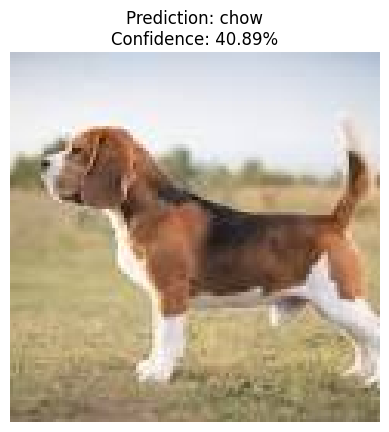

In [55]:
import matplotlib.pyplot as plt

def display_prediction(img_path, prediction_result):
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction: {prediction_result['class']}\nConfidence: {prediction_result['confidence']:.2%}")
    plt.show()

display_prediction(test_image_path, result)

**FAUT SAUVEGARDER LE MODEL**

In [ ]:
# ==============================================
# 7. Graphique de l'Apprentissage 📈
# ==============================================
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()